In [1]:
import os
import math
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, polars as pl
from sklearn.preprocessing import MinMaxScaler
from colorama import Fore, Style
import pickle

import tensorflow as tf, deeptables as dt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets


warnings.filterwarnings('ignore')
print('TensorFlow version:',tf.__version__+',',
      'GPU =',tf.test.is_gpu_available())
print('DeepTables version:',dt.__version__)

/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow version: 2.15.0, GPU = True
DeepTables version: 0.2.6


2024-11-20 08:44:32.060193: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-11-20 08:44:32.060225: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-11-20 08:44:32.060229: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-11-20 08:44:32.060255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 08:44:32.060270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

Learning rate schedule: 0.0001 to 0.001 to 0.001


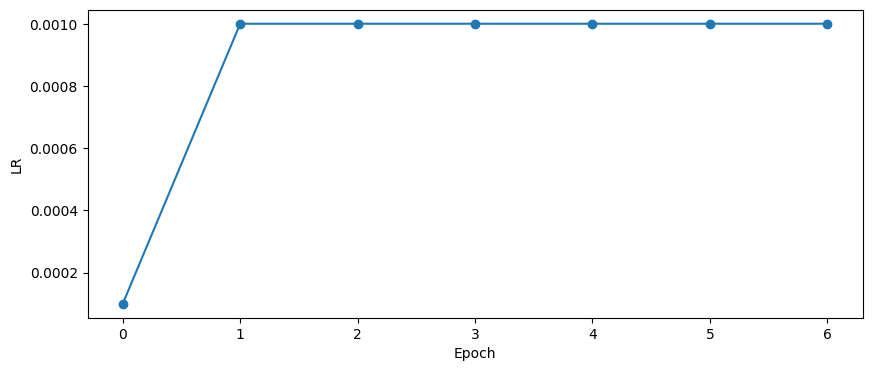

In [3]:
# https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790/notebook
LR_START = 1e-4
LR_MAX = 1e-3
LR_MIN = 1e-3
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR_Scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [4]:
class CFG:
    train_path = '../data/raw/train.csv'
    split_agent_features = True
    scaler = MinMaxScaler()  # Scaler or None
    
    nn = True    
    folds = 5
    epochs = 7
    batch_size = 128
    LR_Scheduler = [LR_Scheduler]
    optimizer = Adam(learning_rate=1e-3)
    conf = ModelConfig(
        auto_imputation=False,
        auto_discrete=False,
        auto_discard_unique=True,
        categorical_columns='auto',
        apply_gbm_features=True,
        fixed_embedding_dim=True,
        embeddings_output_dim=4,
        embedding_dropout=0.2,
        # nets=['dnn_nets'] + ['fm_nets'] + ['cin_nets'],
        # nets = ['dnn_nets'] + ['fm_nets'],
        nets =['dnn_nets'] + ['cin_nets'],
        dnn_params={
            'hidden_units': ((1024, 0.0, True),
                             (512, 0.0, True),
                             (256, 0.0, True),
                             (128, 0.0, True)),
            'dnn_activation': 'relu',
        },
        stacking_op='concat',
        output_use_bias=False,
        optimizer=optimizer,
        task='regression',
        loss='auto',
        metrics=["RootMeanSquaredError"],
        earlystopping_patience=1,
    )

In [5]:
constant_cols = pd.read_csv('../data/constant_columns.csv').columns.to_list()
target_col = 'utility_agent1'
game_col = 'GameRulesetName'
game_rule_cols = ['EnglishRules', 'LudRules']
output_cols = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
dropped_cols = ['Id'] + constant_cols + game_rule_cols + output_cols
agent_cols = ['agent1', 'agent2']

def preprocess_data(df): 
    df = df.drop(filter(lambda x: x in df.columns, dropped_cols))
    if CFG.split_agent_features:
        for col in agent_cols:
            df = df.with_columns(pl.col(col).str.split(by="-").list.to_struct(fields=lambda idx: f"{col}_{idx}")).unnest(col).drop(f"{col}_0")
    df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in agent_cols])            
    df = df.with_columns([pl.col(col).cast(pl.Float32) for col in df.columns if col[:6] not in agent_cols and col != game_col])
    df = df.to_pandas()
    df["utility_agent1_rank"] = (
        df["utility_agent1"].rank(method='dense', ascending=True).astype(int)
    )
    print(f'Data shape: {df.shape}\n')

    cat_cols = df.select_dtypes(include=['category']).columns.tolist()
    non_cat_cols = df.select_dtypes(exclude=['category']).columns.tolist()
    num_cols = [num for num in non_cat_cols if num not in [target_col, game_col, "utility_agent1_rank"]]
    return df, cat_cols, num_cols

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

In [7]:
def train(data, cat_cols, num_cols, scaler):
    split_list = split1.copy()

    X = data.drop([target_col, "utility_agent1_rank", game_col], axis=1)
    y = data[target_col]
    oof = np.zeros(len(data))
    oof_scores = list()
    nn_models = []

    target = "utility_agent1"
    oof_df = pd.DataFrame(
        index=data.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    
    print('nn = '+str(CFG.nn),'\n')
    
    for fi, (train_idx, valid_idx) in enumerate(split_list, 1):
        print("#"*25)
        print(f"### Fold {fi}/{CFG.folds} ...")
        print("#"*25)
        
        os.makedirs(f"../data/working/nn_models/fold{fi}", exist_ok=True)

        if CFG.nn == True:
            print('\n',"nn model training.",'\n')
            K.clear_session()
            nn_model = DeepTable(config=CFG.conf)
            nn_model.fit(X.iloc[train_idx], y.iloc[train_idx],
                      validation_data=(X.iloc[valid_idx], y.iloc[valid_idx]),
                      callbacks=CFG.LR_Scheduler,
                      batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2)
            nn_models.append(nn_model)
            
            # Save model
            # nn_model.save(f'../data/working/nn_models/fold{fi}')
        
            # Avoid some errors
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for j, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(j)
                    CFG.optimizer.weights[j] = tf.Variable(var, name=name)
            CFG.conf = CFG.conf._replace(optimizer=CFG.optimizer)

            oof_preds = nn_model.predict(X.iloc[valid_idx], verbose=1, batch_size=512).flatten()
            rmse = np.round(np.sqrt(np.mean((oof_preds - y.iloc[valid_idx])**2)),4)
            oof_scores.append(rmse)
            print(f'{Fore.GREEN}{Style.BRIGHT}\nFold {fi} | rmse: {rmse}\n')

            oof[valid_idx] = oof_preds
            oof_df.loc[valid_idx, f'{target}_true'] = y.iloc[valid_idx]
            oof_df.loc[valid_idx, f'{target}_pred'] = oof_preds 
            oof_df.loc[valid_idx, 'fold'] = fi
        else:
            raise ValueError("Neural network model not enabled in CFG.")
    
    rmse = np.round(np.sqrt(np.mean((oof - y)**2)),4)
    print(f'{Fore.BLUE}{Style.BRIGHT}Overall CV rmse: {rmse}\n')
    print(f'{Fore.BLUE}{Style.BRIGHT}OOF scores: {oof_scores} (avg: {np.mean(oof_scores):.4f})\n')
    plot_model(nn_model.get_model().model)
    
    # Save OOF predictions
    oof_df.to_csv('../data/results/oof_dt-nn_cv1.csv', index=False)
        
    return nn_models


def infer(data, nn_models, ctb_models, num_cols, scaler):
    return np.mean(
        [model.predict(data, verbose=1, batch_size=512).flatten()
         for model in nn_models
        ],
        axis=0
    )

In [8]:
scaler = CFG.scaler
train_df = pl.read_csv(CFG.train_path)
train_df, cat_cols, num_cols = preprocess_data(train_df)
if scaler is not None:
    print(f'Scaling {len(num_cols)} numerical cols.\n')
    train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

Data shape: (233234, 599)

Scaling 588 numerical cols.



In [9]:
nn_models = train(train_df, cat_cols, num_cols, scaler) 

nn = True 

#########################
### Fold 1/5 ...
#########################

 nn model training. 

11-20 08:44:34 I deeptables.m.deeptable.py 337 - X.Shape=(190558, 596), y.Shape=(190558,), batch_size=128, config=ModelConfig(name='conf-1', nets=['cin_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics=['RootMeanSquaredError'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=False, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='concat', output_use_bias=False, apply_class_weight=False, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x32460a6b0>, loss='auto', dnn_params={'hidden_units': 

11-20 08:44:35 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line

11-20 08:44:35 I deeptables.m.preprocessor.py 261 - Preparing features...
11-20 08:44:35 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.33132100105285645s
11-20 08:44:35 I deeptables.m.preprocessor.py 388 - Categorical encoding...
11-20 08:44:35 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.12087392807006836s
11-20 08:44:35 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
11-20 08:44:36 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16860
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 578
[LightGBM] [Info] Start training from score 0.040548
11-20 08:44:39 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.960453

2024-11-20 08:44:40.582722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 08:44:40.582739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


11-20 08:44:41 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=True, drop_remainder=True
11-20 08:44:41 I deeptables.m.deepmodel.py 231 - Building model...
11-20 08:44:42 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (108)', 'input_continuous_all: (570)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [6, 5, 5, 4, 6, 5, 5, 4, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 

2024-11-20 08:44:45.758333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1488/1488 - 86s - loss: 0.1323 - root_mean_squared_error: 0.3638 - val_loss: 0.2066 - val_root_mean_squared_error: 0.4545 - lr: 1.0000e-04 - 86s/epoch - 58ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/7
1488/1488 - 77s - loss: 0.0891 - root_mean_squared_error: 0.2985 - val_loss: 0.1988 - val_root_mean_squared_error: 0.4459 - lr: 0.0010 - 77s/epoch - 52ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/7
1488/1488 - 77s - loss: 0.0697 - root_mean_squared_error: 0.2640 - val_loss: 0.1882 - val_root_mean_squared_error: 0.4338 - lr: 0.0010 - 77s/epoch - 52ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/7
1488/1488 - 78s - loss: 0.0607 - root_mean_squared_error: 0.2463 - val_loss: 0.1896 - val_root_mean_squared_error: 0.4354 - lr: 0.0010 - 78s/epoch - 53ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/7
1488/1488 - 78s - loss: 0.0541 - root_mean_squared_error: 0.2326

11-20 08:54:03 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line

11-20 08:54:03 I deeptables.m.preprocessor.py 261 - Preparing features...
11-20 08:54:04 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.3211209774017334s
11-20 08:54:04 I deeptables.m.preprocessor.py 388 - Categorical encoding...
11-20 08:54:04 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.1266167163848877s
11-20 08:54:04 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
11-20 08:54:04 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17067
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 590
[LightGBM] [Info] Start training from score 0.047370
11-20 08:54:08 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.95583391

11-20 09:03:46 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line

11-20 09:03:46 I deeptables.m.preprocessor.py 261 - Preparing features...
11-20 09:03:47 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.2917907238006592s
11-20 09:03:47 I deeptables.m.preprocessor.py 388 - Categorical encoding...
11-20 09:03:47 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.12428522109985352s
11-20 09:03:47 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
11-20 09:03:47 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16966
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 590
[LightGBM] [Info] Start training from score 0.045943
11-20 09:03:51 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.8715479

11-20 09:13:25 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line

11-20 09:13:25 I deeptables.m.preprocessor.py 261 - Preparing features...
11-20 09:13:25 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.2815580368041992s
11-20 09:13:25 I deeptables.m.preprocessor.py 388 - Categorical encoding...
11-20 09:13:25 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.13254117965698242s
11-20 09:13:25 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
11-20 09:13:26 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16898
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 595
[LightGBM] [Info] Start training from score 0.047922
11-20 09:13:29 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.7920601

11-20 09:23:03 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line

11-20 09:23:03 I deeptables.m.preprocessor.py 261 - Preparing features...
11-20 09:23:03 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.267653226852417s
11-20 09:23:03 I deeptables.m.preprocessor.py 388 - Categorical encoding...
11-20 09:23:03 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.12052607536315918s
11-20 09:23:03 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
11-20 09:23:04 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16880
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 592
[LightGBM] [Info] Start training from score 0.042994
11-20 09:23:07 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 3.79333496

***